In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools
import copy

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import GlorotNormal
from keras import backend as K

from sklearn.model_selection import KFold 

from collections import Counter

In [3]:
# Hyperparameters
epochs = 12
num_classes = 10
batch_size = 128
learning_rate = 0.0001

kf = KFold(n_splits=10)
initializer = GlorotNormal()

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
"""
Data obtained from https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
"""

trnData = pd.read_csv('kaggle/input/digit-recognizer/train.csv')
tstData = pd.read_csv('kaggle/input/digit-recognizer/test.csv')

In [5]:
print(Counter(trnData["label"]))

Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


## Get Training Data

In [6]:
trnData.info()
labels = trnData["label"]
trnImgs = []

for i in range(trnData.shape[0]):
    trnImgs.append(trnData.loc[i][1:])

trnImgs = np.array(trnImgs)
print("Training Data Shape:", trnImgs.shape)
print("Labels Shape:", labels.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
Training Data Shape: (42000, 784)
Labels Shape: (42000,)


## Get Testing Data

In [7]:
tstData.info()
tstImgs = []

for i in range(tstData.shape[0]):
    tstImgs.append(tstData.loc[i])
    
tstImgs = np.array(tstImgs)
print("Testing Data Shape:", tstImgs.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
Testing Data Shape: (28000, 784)


In [8]:
# imgs[image number][pixel number]
print(trnImgs[:,:].shape)
print(tstImgs[:,:].shape)
print(labels.shape)

(42000, 784)
(28000, 784)
(42000,)


In [9]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.

    E.g. for use with categorical_crossentropy.

    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.

    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=np.float32)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [11]:
# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (1, img_rows, img_cols) if K.image_data_format() == 'channels_first' else (img_rows, img_cols, 1)

## Define model

In [13]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_initializer=initializer, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer=initializer, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,746 (1.13 MB)

 Trainable params: 296,746 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model with K-Fold Cross Validation

In [15]:
validation_scores = []
test_scores = []

split_num = 0
for train_index, test_index in kf.split(trnImgs):
    print(f"\nTraining on Split #{split_num}\n")
    split_num += 1
    
    x_train, x_test = copy.deepcopy(trnImgs[train_index]), copy.deepcopy(trnImgs[test_index])
    y_train, y_test = copy.deepcopy(labels[train_index]), copy.deepcopy(labels[test_index])

    # add noise to expand dataset
    x_train = np.vstack((x_train, x_train + np.random.normal(size=x_train.shape)))
    y_train = np.hstack((y_train, y_train))

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)


    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
    y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)
    
    
    # Training
    start_time = datetime.now()

    history = model.fit(x_train, y_train_one_hot,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test_one_hot))

    print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

    # Testing Score
    start_time = datetime.now()
    score = model.evaluate(x_test, y_test_one_hot, verbose=0)
    test_scores.append(score)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))
    
    # Training Score
    start_time = datetime.now()
    score_train = model.evaluate(x_train, y_train_one_hot, verbose=0)
    validation_scores.append(score_train)
    print('Train loss:', score_train[0])
    print('Train accuracy:', score_train[1])

    print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))


Training on Split #0

75600 train samples
4200 test samples
Epoch 1/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.1024 - loss: 2.3349 - val_accuracy: 0.1960 - val_loss: 2.2472
Epoch 2/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.1498 - loss: 2.2645 - val_accuracy: 0.3274 - val_loss: 2.1776
Epoch 3/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.1991 - loss: 2.2015 - val_accuracy: 0.4495 - val_loss: 2.1072
Epoch 4/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.2579 - loss: 2.1385 - val_accuracy: 0.5505 - val_loss: 2.0332
Epoch 5/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.3158 - loss: 2.0709 - val_accuracy: 0.6483 - val_loss: 1.9562
Epoch 6/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.3648 - loss: 2.0077 - val_accuracy: 0.6840 - val_loss: 1.8763
Epoch 7/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.4112 - loss: 1.9351 - val_accuracy: 0.7048 - val_loss: 1.7945
Epoch 8/12
591/591 ━━━━━━━━━━

591/591 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.7931 - loss: 0.6821 - val_accuracy: 0.8736 - val_loss: 0.4865
Epoch 10/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7932 - loss: 0.6830 - val_accuracy: 0.8738 - val_loss: 0.4798
Epoch 11/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7974 - loss: 0.6659 - val_accuracy: 0.8748 - val_loss: 0.4730
Epoch 12/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.7971 - loss: 0.6681 - val_accuracy: 0.8776 - val_loss: 0.4667
Time Elapsed: 331.027763 seconds
Test loss: 0.4666856825351715
Test accuracy: 0.8776190280914307
Time Elapsed: 0.616059 seconds
Train loss: 0.4591129720211029
Train accuracy: 0.8834259510040283
Time Elapsed: 8.342085 seconds

Training on Split #4

75600 train samples
4200 test samples
Epoch 1/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8027 - loss: 0.6521 - val_accuracy: 0.8869 - val_loss: 0.4473
Epoch 2/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.8012

Epoch 4/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8525 - loss: 0.4850 - val_accuracy: 0.9048 - val_loss: 0.3340
Epoch 5/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8542 - loss: 0.4851 - val_accuracy: 0.9062 - val_loss: 0.3322
Epoch 6/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8491 - loss: 0.4938 - val_accuracy: 0.9064 - val_loss: 0.3306
Epoch 7/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8542 - loss: 0.4820 - val_accuracy: 0.9067 - val_loss: 0.3289
Epoch 8/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8579 - loss: 0.4713 - val_accuracy: 0.9071 - val_loss: 0.3268
Epoch 9/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.8573 - loss: 0.4766 - val_accuracy: 0.9074 - val_loss: 0.3251
Epoch 10/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.8580 - loss: 0.4719 - val_accuracy: 0.9083 - val_loss: 0.3233
Epoch 11/12
591/591 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8554 - loss: 0.4742 

In [16]:
validation_scores = np.array(validation_scores)
test_scores = np.array(test_scores)

val_loss, val_accuracy = validation_scores[:,0], validation_scores[:,1]
test_loss, test_accuracy = test_scores[:,0], test_scores[:,1]

print(val_accuracy)
print(test_accuracy)

print(f"Average Validation Accuracy: {np.mean(val_accuracy)}")
print(f"Average Test Accuracy: {np.mean(test_accuracy)}")

[0.7655291  0.83271164 0.8644709  0.88342595 0.89440477 0.90205026
 0.90812171 0.91365081 0.91652119 0.92138886]
[0.77071428 0.83499998 0.86309522 0.87761903 0.89738095 0.90595239
 0.90714288 0.90880954 0.92380953 0.92261904]
Average Validation Accuracy: 0.880227518081665
Average Test Accuracy: 0.8812142848968506


## Evaluate Model

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


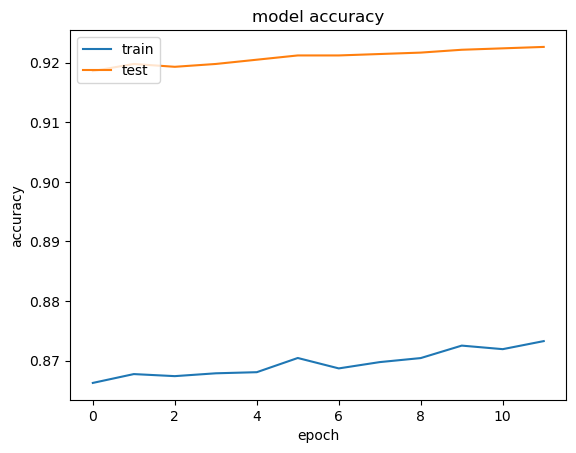

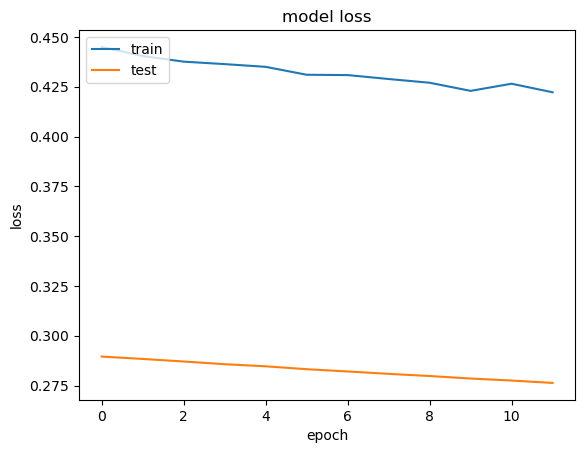

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
predictions = model.predict(x_test, verbose=0)
yitest = np.argmax(y_test_one_hot, axis=1)

normPred = []
for row in predictions:
    normPred.append(np.floor(row/np.max(row)))
    
normPred = np.array(normPred)

print(f"Model Accuracy: {np.count_nonzero(normPred == y_test_one_hot)/(normPred.flatten()).shape[0]}")

yptest = np.argmax(predictions, axis=1)
# print (yitest)
# print (yptest)

cfm_k2 = confusion_matrix(yitest, yptest)

Model Accuracy: 0.9845238095238096


## Confusion Matrix

Confusion matrix, without normalization


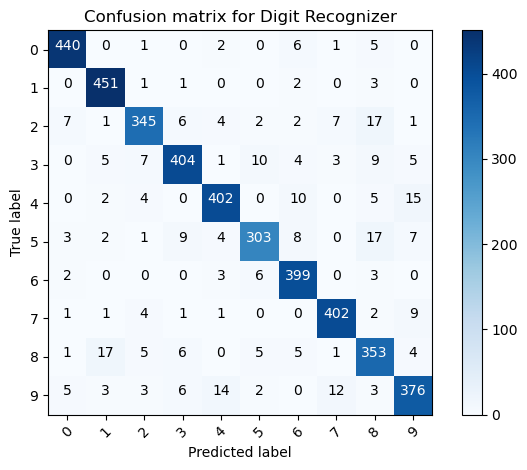

In [19]:
plot_confusion_matrix(cfm_k2, classes=range(10), 
                      title='Confusion matrix for Digit Recognizer')